# Renting or Buying a Home

The idea of this analysis is to compare the long term wealth growth of owning a home verse renting.

Load Modules

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

General Inputs

In [2]:
gen_inputs = {
    'income' : 75000, #US average = $57,238
    'income_raise_rate' : .033, #US average = 3.30%
    'market_return' : .092, #US average = 9.20%
    'monthly_cost_of_living' : 1459, #US average = $1459    
    'cost_of_living_rate' : .0322, #US average = 3.22%
    'start_date' : date.today() #datetime.date(yyyy,m,d)
    }

Home Buying Inputs

In [3]:
own_inputs = {
    'home_value' : 225000, #US average = $325,000
    'down_payment' : 25000, #US average = 5% of Home Value
    'starting_loan_amount' : 200000, 
    'loan_interest_rate' : .0375,
    'home_price_rate' : .03, #US average = 1.5% to 4.8%
    'years' : 30, 
    'propetry_taxes' : 275, #US average = 6.786% of home value (Chicago)
    'home_insurance' : 75, 
    'additional_principle' : 500,
    'home_maintence' : 2000, #US average = $2,000 to $8,000
    'hoa_fee' : 342, #US average = $342
    'hoa_rate' : .059, #US average = 5.90%
    'buying_costs' : 11250, #US average = 2% to 5% of Home Value
    'closing_costs' : 16000, #US average = $16,000
    'portfolio_balance' : 0, 
    'savings_rate' : .079, #US average = 7.90%
    'rental_income' : 1500, #US average = 
    }

Renting Inputs

In [4]:
rent_inputs = {
    'monthly_rent' : 1175, #US average = $1,943 (Chicago)
    'rent_inflation_rate' : .02, #US average = 2.0%
    'portfolio_balance' : 25000, 
    'personal_savings_rate' : .50, #US average = 7.90%
    }

In [5]:
#Supplemental DataFrames 
#Example uses tax information for Chicago.
taxdf = pd.DataFrame(columns=['Pay','Tax Rate'])
taxdf['Pay'] = [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 250000]
taxdf['Pay'] = taxdf['Pay'].astype(float)
taxdf['Tax Rate'] = [.1147, .1594, .1870, .2017, .2106, .2304, .2469, .2593, .2689, .2773, .2854, .2921, .2978, .2995, .2998, .3001, .3003, .3037, .3079, .3117, .3320]

hometax = pd.DataFrame(columns=['Local','Amount'])
hometax['Local'] = ['State','County','Chicago']
hometax['Amount'] = [1,0.5,3]

capitaltax = pd.DataFrame(columns=['Income','Rate'])
capitaltax['Income'] = [40000,441450,44151]
capitaltax['Rate'] = [0,.15,.20]


Functions

In [6]:
#Functions
def growthCalc(data,item,rate):
    tempincome = item
    nincome = [[item]]*12
    for i in range(int((len(data)/12)-1)):
        tempincome = round(tempincome + (rate*tempincome),2)
        nincome.append([tempincome]*12)
    return sum(nincome,[])  

def marketRet(data,start,rate):
    portlst = []
    yearmarks = [12*i for i in list(range(own_inputs['years']))]
    port = start
    for i in range(len(data)):
        if i in yearmarks:
            port = port + data['Savings'].iloc[i]
            port = port + (port*rate)
            portlst.append(round(port,2))
        else:
            port = port + data['Savings'].iloc[i]
            portlst.append(round(port,2))
    return portlst     

def capitalTax(data):
    if data - 441450 > 0: tax20 = (data-441451)*.20
    else: tax20 = 0
    if data - 40000 > 0: tax15 = (data - 40000)*.15
    else: tax15 = 0
    return round(data - tax20 - tax15,2)

def rent_own_Calcs(gen,own,rent,printn):
    #General DataFrame
    rng = pd.date_range(gen['start_date'], periods=own['years'] * 12, freq='MS')
    rng.name = "Date"
    gdf = pd.DataFrame(index=rng,columns=['Income', 'Taxes', 'Monthly Income', 'Cost of Living'], dtype='float')
    gdf.reset_index(inplace=True)
    gdf.index += 1
    gdf.index.name = "Period"
    gdf['Income'] = growthCalc(gdf,gen['income'],gen['income_raise_rate'])
    gdf['Cost of Living'] = growthCalc(gdf,gen['monthly_cost_of_living'],gen['cost_of_living_rate'])
    gdf['Taxes'] = [taxdf[taxdf['Pay'] == i]['Tax Rate'].item() for i in list(round(gdf['Income'],-4))]
    gdf['Monthly Income'] = round((gdf['Income'] - (gdf['Income']*gdf['Taxes']))/12,2)

#Renting DataFrame
    rng = pd.date_range(gen['start_date'], periods=own['years'] * 12, freq='MS')
    rng.name = "Date"
    rdf = pd.DataFrame(index=rng,columns=['Rent', 'After Rent and Living','Savings', 'After Savings', 'Portfolio Value'], dtype='float')
    rdf.reset_index(inplace=True)
    rdf.index += 1
    rdf.index.name = "Period"
    rdf['Rent'] = growthCalc(rdf,rent['monthly_rent'],rent['rent_inflation_rate'])
    rdf['After Rent and Living'] = gdf['Monthly Income'] - gdf['Cost of Living'] - rdf['Rent']
    rdf['Savings'] = rdf['After Rent and Living']*rent['personal_savings_rate']
    rdf['After Savings'] = rdf['After Rent and Living'] - rdf['Savings']
    rdf['Portfolio Value'] = marketRet(rdf,rent['portfolio_balance'],gen['market_return'])

    #Home Buying DataFrame
    monthly_applied_loan = np.pmt(own['loan_interest_rate']/12,own['years']*12,own['starting_loan_amount'])*-1
    monthly_minimum_payments = monthly_applied_loan + own['propetry_taxes'] + own['home_insurance'] + own['additional_principle']

    rng = pd.date_range(gen['start_date'], periods=own['years'] * 12, freq='MS')
    rng.name = "Payment_Date"
    df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 'Addl_Principal', 'Balance'], dtype='float')
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    df["Payment"] = np.pmt(own['loan_interest_rate']/12, own['years']*12, own['starting_loan_amount'])
    df["Principal"] = np.ppmt(own['loan_interest_rate']/12, df.index, own['years']*12, own['starting_loan_amount'])
    df["Interest"] = np.ipmt(own['loan_interest_rate']/12, df.index, own['years']*12, own['starting_loan_amount'])
    df["Addl_Principal"] = -own['additional_principle']
    df["Balance"] = 0
    df.loc[1, "Balance"] = own['starting_loan_amount'] + df.loc[1, "Principal"] + df.loc[1, "Addl_Principal"]

    for i in range(2, len(df)+1):
        # Get the previous balance as well as current payments
        prev_balance = df.loc[i-1, 'Balance']
        principal = df.loc[i, 'Principal']
        addl_principal = df.loc[i, "Addl_Principal"]

        # If there is no balance, then do 0 out the principal and interest
        if prev_balance == 0:
            df.loc[i, ['Payment', 'Principal', 'Interest', 'Balance', 'Addl_Principal']] = 0
            continue

        # If this payment does not pay it off, reduce the balance
        if abs(principal + addl_principal) <= prev_balance:
            df.loc[i, 'Balance'] = principal + prev_balance + addl_principal

        # If it does pay it off, zero out the balance and adjust the final payment
        else:
            # Just adjust the principal down
            if prev_balance <= abs(principal):
                principal = -prev_balance
                addl_principal = 0
            else:
                addl_principal = (prev_balance - abs(monthly_applied_loan))
            df.loc[i, 'Balance'] = 0
            df.loc[i, 'Principal'] = principal
            df.loc[i, 'Addl_Principal'] = addl_principal
            df.loc[i, "Payment"] = principal +  df.loc[i, "Interest"]

    df = df.round(2)

    #Additional Home Buying DataFrame
    df['Taxes'] = own['propetry_taxes']
    df['HOA Fee'] = growthCalc(df,own['hoa_fee'],own['hoa_rate'])
    df['Insurance'] = own['home_insurance']
    df['Maintence'] = own['home_maintence']
    df['Monthly Total'] = (df['Payment']*-1) + df['Taxes'] + df['HOA Fee'] + df['Insurance'] + df['Maintence'] 
    df['Home Appr'] = growthCalc(df,own['home_value'],own['home_price_rate'])
    df['Rental Income'] = growthCalc(df,own['rental_income'],rent['rent_inflation_rate'])
    df['Rental Income Tax Rate'] = [taxdf[taxdf['Pay'] == i]['Tax Rate'].item() if i < 200000 else .3320 for i in list(round(((df['Rental Income']*12)+gdf['Income']),-4))]
    df['After Fixed and Living Costs'] = gdf['Monthly Income'] - gdf['Cost of Living'] - df['Monthly Total'] + round(df['Rental Income'] - (df['Rental Income']*df['Rental Income Tax Rate']),2)
    df['Savings'] = df['After Fixed and Living Costs']*own['savings_rate']
    df['Income After Savings'] = df['After Fixed and Living Costs'] - df['Savings']
    df['Portfolio Value'] = marketRet(df,own['portfolio_balance'],gen['market_return'])

    #Remove periods after paid off
    indexNames = df[df['Principal'] == 0.0 ].index
    df.drop(indexNames , inplace=True)
    gdf.drop(indexNames , inplace=True)
    rdf.drop(indexNames , inplace=True)

    #Profitablilty Analysis
    home_port_return = capitalTax(round(df['Portfolio Value'].iloc[-1] - own['portfolio_balance'] - sum(df['Savings']),2))
    home_return = round(df['Home Appr'].iloc[-1] - ((df['Home Appr'].iloc[-1]/1000)*sum(hometax['Amount']) + own['home_value'] + own['buying_costs'] + own['closing_costs']),2)
    print(' ')
    print('Return from Ownership: $',home_port_return + home_return)
    rent_port_return = capitalTax(rdf['Portfolio Value'].iloc[-1] - rent['portfolio_balance'] - sum(rdf['Savings']))
    print('Return from Renting: $',rent_port_return)
    print(' ')
    print('Paid off in :', len(df)/12,' years')

    if printn == 1:
        plt.plot(rdf['Portfolio Value'],label='Renting')
        plt.plot(df['Portfolio Value']+df['Home Appr']-own['home_value'],label='Ownership (Including Home Appr.)')
        plt.title('Portfolio Value')
        plt.legend()
        plt.show()

        plt.plot(df['Monthly Total'],label='Total Monthly Payments')
        plt.plot(df['After Fixed and Living Costs'],label='After Loan and Living')
        plt.plot(df['Savings'],label='Savings')
        plt.plot(df['Income After Savings'],label='Left over after Fixed Costs')
        plt.title('Ownership')
        plt.legend()
        plt.show()

        plt.plot(rdf['Rent'],label='Rent')
        plt.plot(rdf['After Rent and Living'],label='After Rent and Living')
        plt.plot(rdf['Savings'],label='Savings')
        plt.plot(rdf['After Savings'],label='Left over after Fixed Costs')
        plt.title('Renting')
        plt.legend()
        plt.show()
        
        plt.plot(gdf['Monthly Income'],label='Monthly Income after Tax')
        plt.plot(gdf['Cost of Living'],label='Cost of Living')
        plt.plot(rdf['After Rent and Living']+gdf['Cost of Living'],label='After Rent and Living')
        plt.plot(df['After Fixed and Living Costs']+gdf['Cost of Living'],label='After Loan and Living')
        plt.title('General')
        plt.legend()
        plt.show()
    
    return [[home_return,rent_port_return],[gdf,df,rdf]]

 
Return from Ownership: $ 143358.14
Return from Renting: $ 381951.22
 
Paid off in : 18.0  years


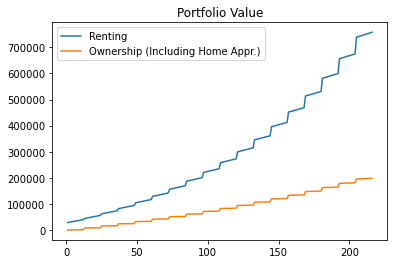

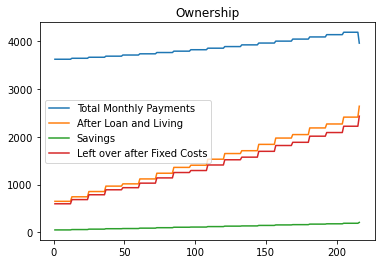

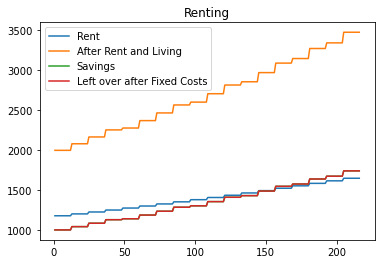

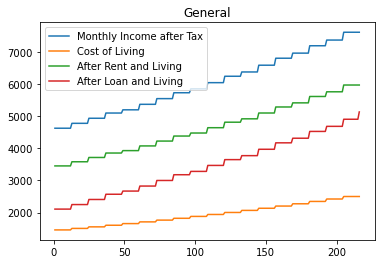

In [7]:
r_o = rent_own_Calcs(gen_inputs, own_inputs, rent_inputs,1)

In [8]:
r_o[0]

[117967.22, 381951.22]

In [9]:
#General DataFrame
print('Starting')
print(' ')
print(r_o[1][0].iloc[0])
print(' ')
print('Ending')
print(' ')
print(r_o[1][0].iloc[-1])

Starting
 
Date              2020-09-01 00:00:00
Income                          75000
Taxes                          0.2593
Monthly Income                4629.38
Cost of Living                   1459
Name: 1, dtype: object
 
Ending
 
Date              2038-08-01 00:00:00
Income                         130247
Taxes                          0.2978
Monthly Income                 7621.6
Cost of Living                 2500.6
Name: 216, dtype: object


In [10]:
#Ownership DataFrame
print('Starting')
print(' ')
print(r_o[1][1].iloc[0])
print(' ')
print('Ending')
print(' ')
print(r_o[1][1].iloc[-1])

Starting
 
Payment_Date                    2020-09-01 00:00:00
Payment                                     -926.23
Principal                                   -301.23
Interest                                       -625
Addl_Principal                                 -500
Balance                                      199199
Taxes                                           275
HOA Fee                                         342
Insurance                                        75
Maintence                                      2000
Monthly Total                               3618.23
Home Appr                                    225000
Rental Income                                  1500
Rental Income Tax Rate                       0.2689
After Fixed and Living Costs                  648.8
Savings                                     51.2552
Income After Savings                        597.545
Portfolio Value                               55.97
Name: 1, dtype: object
 
Ending
 
Payment_Date       

In [11]:
#Renting DataFrame
print('Starting')
print(' ')
print(r_o[1][2].iloc[0])
print(' ')
print('Ending')
print(' ')
print(r_o[1][2].iloc[-1])

Starting
 
Date                     2020-09-01 00:00:00
Rent                                    1175
After Rent and Living                1995.38
Savings                               997.69
After Savings                         997.69
Portfolio Value                      28389.5
Name: 1, dtype: object
 
Ending
 
Date                     2038-08-01 00:00:00
Rent                                 1645.28
After Rent and Living                3475.72
Savings                              1737.86
After Savings                        1737.86
Portfolio Value                       758120
Name: 216, dtype: object
